# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
# Задание:
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

## Подготовка данных

Импортируем необходимые библиотеки:
- pandas для работы с табличными данными
- sklearn для работы с моделями машинного обучения
- matplotlib и seaborn для построения графиков

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score,confusion_matrix, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme() 

Выгружаем данные из csv-файла в DataFrame

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0




В столбце 'Tenure' обнаружены пропуски. Заполним их значением -1, изменим тип Float на Object  и применим ОНЕ

In [5]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [6]:
data[data['Tenure'].isna()]['Tenure'] = -1 # заменяем None на -1


/tmp/ipykernel_305/2051577180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['Tenure'].isna()]['Tenure'] = -1 # заменяем None на -1


In [7]:
data['Tenure'] = data['Tenure'].astype('object') # меняем тип данных для того чтобы применить прямое кодирование в дальнейшем

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   object 
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 1.1+ MB


Типы данных указаны правильно, пропусков нет,можно приступать к исследованию

## Исследование задачи

В датафрейме есть категориальные данные, для решения задачи классификации, а именно: уйдет клиент из банка или нет, нужно привести эти данные в цифровой вид, провести прямое кодирование (OHE). 
В первую очередь проверим результаты на несбалансированной выборке.

Чтобы не плодить лишние столбцы исключим из data столбец 'Surname','RowNumber' и 'CustomerId'. 

In [9]:
data = data.drop(['Surname','RowNumber','CustomerId'], axis=1)

In [10]:
target = data['Exited'] # выделяем целевой признак
features = data.drop('Exited', axis=1) # отделяем целевой признак от параметров модели

Разделяем выборку на 3 части: тренировочная-60%, валидационная-20% и тестовая-20% 

In [11]:
feature_train,feature_valid_test,target_train,target_valid_test = train_test_split(features, target, 
                                                                                   test_size = 0.4, random_state=12345)

In [12]:
feature_valid, feature_test,target_valid,target_test = train_test_split(feature_valid_test, 
                                                                        target_valid_test, test_size = 0.5, random_state=12345)

Масштабируем признаки:

Для каждой выборки проводим OHE. Во избежание дамми-ловушки выставляем параметр drop_first=True

In [13]:
numeric = ['EstimatedSalary','Balance','Age','CreditScore','NumOfProducts'] # выбираем численные признаки
scaler = StandardScaler()
scaler.fit(feature_train[numeric])
feature_train[numeric] = scaler.transform(feature_train[numeric])
feature_valid[numeric] = scaler.transform(feature_valid[numeric])
feature_test[numeric] = scaler.transform(feature_test[numeric])
pd.options.mode.chained_assignment = None # избавляемся от ошибки

/tmp/ipykernel_305/462568195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_train[numeric] = scaler.transform(feature_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_305/462568195.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [14]:
feature_train = pd.get_dummies(feature_train, drop_first=True)
feature_valid = pd.get_dummies(feature_valid, drop_first=True)
feature_test = pd.get_dummies(feature_test, drop_first=True)

In [15]:
feature_train.head()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure_1.0,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0
7479,-0.886751,-0.373192,1.232271,-0.891560,1,0,-0.187705,0,1,1,0,0,0,0,0,0,0,1,0,0
3411,0.608663,-0.183385,0.600563,-0.891560,0,0,-0.333945,0,0,0,0,0,0,0,0,0,0,1,0,0
6027,2.052152,0.480939,1.027098,0.830152,0,1,1.503095,1,0,1,0,0,1,0,0,0,0,0,0,0
1247,-1.457915,-1.417129,-1.233163,0.830152,1,0,-1.071061,0,0,1,0,0,0,0,0,1,0,0,0,0
3716,0.130961,-1.132419,1.140475,-0.891560,0,0,1.524268,1,0,0,0,1,0,0,0,0,0,0,0,0


Проверим три модели: Логистическая регрессия, дерево решений и случайный лес.

Проверяем F1-меру логистической регрессии:

In [16]:
model_reg = LogisticRegression(random_state=12345, solver ='liblinear')
model_reg.fit(feature_train,target_train)
pred_reg_valid = model_reg.predict(feature_valid)
F1_reg = f1_score(target_valid, pred_reg_valid)
print(f'F1-мера: {F1_reg}')

F1-мера: 0.32605042016806723


Проверяем F1-меру случайного леса:

Сначала зафиксируем небольшое число деревьев и подберем оптимальную глубину дерева

In [17]:
best_depth = 0
max_f1 = 0
for depth in range(1,25): # Ищем наилучшую глубину дерева
    
    
    model_rand_tree = RandomForestClassifier(n_estimators=10 ,max_depth=depth,random_state=12345)
    model_rand_tree.fit(feature_train,target_train)
    pred__rand_tree_valid = model_rand_tree.predict(feature_valid)
    F1_forest = f1_score(target_valid, pred__rand_tree_valid)
    
    if F1_forest > max_f1:
        max_f1 = F1_forest
        best_depth = depth
    else:
        pass    
    
print(f'Глубина: {best_depth}')
print(f'F1-мера: {max_f1}')

Глубина: 16
F1-мера: 0.5964912280701754


Подобрав оптимальное значение глубины подберем лучшее количество деревьев

In [18]:
best_estimator = 0
max_f1 = 0
for estimator in range(10,120,20): # Ищем наилучшее количество деревьев
    
    
    model_rand_tree = RandomForestClassifier(n_estimators=estimator ,max_depth=16,random_state=12345)
    model_rand_tree.fit(feature_train,target_train)
    pred__rand_tree_valid = model_rand_tree.predict(feature_valid)
    F1_forest = f1_score(target_valid, pred__rand_tree_valid)
    
    if F1_forest > max_f1:
        max_f1 = F1_forest
        best_estimator = estimator
    else:
        pass    
print()  
print(f'Кол-во деревьев: {best_estimator}')
print(f'F1-мера: {max_f1}')


Кол-во деревьев: 10
F1-мера: 0.5964912280701754


Проверяем F1-меру дерева решений:

In [19]:
best_depth = 0
max_f1 = 0
for depth in range(1,21): # Ищем наилучшую глубину дерева
    model_tree = DecisionTreeClassifier(max_depth=depth,random_state=12345)
    model_tree.fit(feature_train,target_train)
    pred_tree_valid = model_tree.predict(feature_valid)
    F1_tree = f1_score(target_valid,pred_tree_valid)
    
    if F1_tree > max_f1:
        max_f1 = F1_tree
        best_depth = depth
    else:
        pass    
 
print(f'Глубина: {best_depth}')
print(f'F1-мера: {max_f1}')    

Глубина: 6
F1-мера: 0.56752655538695


Построим матрицу ошибок для каждой модели чтобы оценить баланс классов

In [20]:
model_reg = LogisticRegression(random_state=12345, solver='liblinear')
model_reg.fit(feature_train,target_train)
pred_reg_valid = model_reg.predict(feature_valid)
print(confusion_matrix(target_valid, pred_reg_valid))

[[1502   80]
 [ 321   97]]


In [21]:
model_rand_tree = RandomForestClassifier(n_estimators=10 ,max_depth=16,random_state=12345)
model_rand_tree.fit(feature_train,target_train)
pred__rand_tree_valid = model_rand_tree.predict(feature_valid)
print(confusion_matrix(target_valid, pred__rand_tree_valid))

[[1520   62]
 [ 214  204]]


In [22]:
model_tree = DecisionTreeClassifier(max_depth=6,random_state=12345)
model_tree.fit(feature_train,target_train)
pred_tree_valid = model_tree.predict(feature_valid)
print(confusion_matrix(target_valid, pred_tree_valid))

[[1528   54]
 [ 231  187]]


### Вывод

В данных явное преобладание негативных ответов что мешает модели правильно обучиться.

Из трех исследванных моделей хуже всех себя показала логистическая регрессия (F1-мера = 0.326).
А лучше всех - случайный лес (F1-мера = 0.596)

## Борьба с дисбалансом

Сделаем данные более сбалансированными и проведем исследование еще раз.

Попробуем проверить логистическую регрессию со встроенным параметром class_weight='balanced'

In [23]:
model_reg = LogisticRegression(class_weight='balanced',random_state=12345, solver='liblinear')
model_reg.fit(feature_train,target_train)
pred_reg_valid = model_reg.predict(feature_valid)
F1_reg = f1_score(target_valid,pred_reg_valid)
print(f'F1-мера: {F1_reg}')

F1-мера: 0.4887737478411054


сразу смотрим матрицу ошибок:

In [24]:
print(confusion_matrix(target_valid, pred_reg_valid))

[[1125  457]
 [ 135  283]]


Для моделей сделаем выборку более сбалансированной путем увеличения в ней количества положительных ответов 

Для этого создадим функцию, которая увеличит количество правельных ответов в указанное количество раз и перемешает данные

In [25]:
def upsample(feature, target, repeat):
    features_zeros = feature[target == 0]
    features_ones = feature[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [26]:
features_upsampled_train, target_upsampled_train = upsample(feature_train, target_train, 4)


Проверяем дерево решений:

In [27]:
best_depth = 0
max_f1 = 0
for depth in range(1,21): 
    model_tree = DecisionTreeClassifier(max_depth=depth,random_state=12345)
    model_tree.fit(features_upsampled_train,target_upsampled_train)
    pred_tree_valid = model_tree.predict(feature_valid)
    F1_tree = f1_score(target_valid,pred_tree_valid)
    
    if F1_tree > max_f1:
        max_f1 = F1_tree
        best_depth = depth
    else:
        pass    
 
print(f'Глубина: {best_depth}')
print(f'F1-мера: {max_f1}')    

Глубина: 5
F1-мера: 0.5948827292110873


Проверяем логистическую регрессию:

In [28]:
model_reg = LogisticRegression(random_state=12345, class_weight='balanced',solver='liblinear')
model_reg.fit(features_upsampled_train,target_upsampled_train)
pred_reg_valid = model_reg.predict(feature_valid)
F1_reg = f1_score(target_valid,pred_reg_valid)
print(f'F1-мера: {F1_reg}')

F1-мера: 0.4887737478411054


Проверяем сучайный лес:

In [29]:
best_depth = 0
max_f1 = 0
for depth in range(1,25): # Ищем наилучшую глубину дерева
    
    
    model_rand_tree = RandomForestClassifier(n_estimators=10 ,max_depth=depth,random_state=12345)
    model_rand_tree.fit(features_upsampled_train,target_upsampled_train)
    pred__rand_tree_valid = model_rand_tree.predict(feature_valid)
    F1_forest = f1_score(target_valid, pred__rand_tree_valid)
    
    if F1_forest > max_f1:
        max_f1 = F1_forest
        best_depth = depth
    else:
        pass    
    
print(f'Глубина: {best_depth}')
print(f'F1-мера: {max_f1}')

best_estimator = 0
max_f1 = 0


Глубина: 9
F1-мера: 0.6030456852791878


In [30]:
best_estimator = 0
max_f1 = 0
for estimator in range(10,120,20): # Ищем наилучшее количество деревьев
      
    model_rand_tree = RandomForestClassifier(n_estimators=estimator ,max_depth=9,random_state=12345)
    model_rand_tree.fit(features_upsampled_train,target_upsampled_train)
    pred__rand_tree_valid = model_rand_tree.predict(feature_valid)
    F1_forest = f1_score(target_valid, pred__rand_tree_valid)
    
    if F1_forest > max_f1:
        max_f1 = F1_forest
        best_estimator = estimator
    else:
        pass    
print()  
print(f'Кол-во деревьев: {best_estimator}')
print(f'F1-мера: {max_f1}')


Кол-во деревьев: 50
F1-мера: 0.6276150627615062


In [31]:
model_rand_tree = RandomForestClassifier(n_estimators=50 ,max_depth=9,random_state=12345)
model_rand_tree.fit(features_upsampled_train,target_upsampled_train)
pred__rand_tree_valid = model_rand_tree.predict(feature_valid)
F1_forest = f1_score(target_valid, pred__rand_tree_valid)
print(f'F1-мера: {F1_forest}')

F1-мера: 0.6276150627615062


### Вывод

Балансировка путем увеличения выборки дала положительный результат.
F1-мера для :

   - логистической регрессии равна 0,48
   - дерева решений равна 0,59
   - случайного леса равна 0,63

Необходимый по условию задания порог F1-меры прошли две модели (дерево решений и случайный лес).
Для тестирования выбираем наилучший результат - модель случайного леса   
    

## Тестирование модели

Проверим модель случайного леса на тестовой выборке

In [32]:
model_rand_tree = RandomForestClassifier(n_estimators=50 ,max_depth=9,random_state=12345)
model_rand_tree.fit(features_upsampled_train,target_upsampled_train)
pred__rand_tree_valid = model_rand_tree.predict(feature_test)
F1_forest = f1_score(target_test, pred__rand_tree_valid)
print(f'F1-мера: {F1_forest}')

F1-мера: 0.6008403361344538


### Вывод

Случайный лес на тестовой выборке показал хороший результат .
По условию необходимо достичь значения F1-меры 0.59, случайный лес дал результат 0.6 

## Метрика AUC-ROC


Дополнительно сравним метрику AUC-ROC с F1-мерой

In [33]:
probabilities_test = model_reg.predict_proba(feature_test) # рассчитываем вероятность для каждого параметра
probabilities_one_test = probabilities_test[:, 1] # передаем вероятности положительного исхода в переменную probabilities_one_test

In [34]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
# с помощью roc_curve получаем значений порога и TPR, FPR


Строим ROC кривую

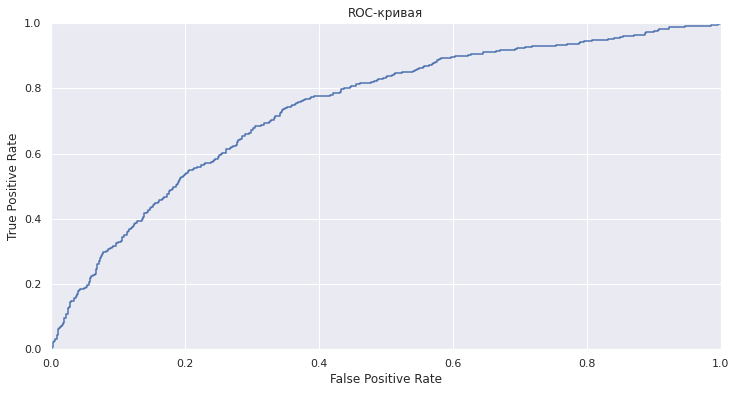

In [35]:

plt.figure(figsize=(12,6)) # Создаем оси
plt.plot(fpr, tpr) # передаем х и у параметры
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 


In [36]:
# считаем площадь под ROC кривой
auc_roc = roc_auc_score(target_test,probabilities_one_test)
print(auc_roc)

0.7401775822963372


### Вывод

Значение auc_roc = 0.74, это больше чем auc_roc для случайной модели (0.5) и больше F1-меры (0,6)

# Вывод

В ходе исследования были подготовлены данные и проверены три модели: Логистическая регрессия, Случайный лес и Дерево решений.
Исследования были проведены для несбалансированных и сбалансированных выборок, затем выбрана лучшая модель, на которой сделали контрольное тестирование.
Дополнительно была выведена метрика auc_roc которая показывает соотношениеполноты и точности работы модели.

Наилучший показатель после балансировки классов показала модель случайного леса с значением F1-меры = 0.6, значением AUC-ROC =0.74  

F1-мера больше 0.59 - задача выплнена.